In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sqlite3
from datetime import datetime
from pandas import Series, DataFrame

%matplotlib inline

In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


### Выгрузка данных из MongoDB и их начальная обработка

In [114]:
# используем данные,полученные из базы данных
data = pd.read_csv('./data_.csv', low_memory=False, sep = "\t")
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,000000000054,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1582569031,2020-02-24T18:30:31Z,1582569032,2020-02-24T18:30:32Z,Limonade artisanale a la rose,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000000000114,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1580066482,2020-01-26T19:21:22Z,1663692166,2022-09-20T16:42:46Z,Chocolate n 3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000018227,http://world-en.openfoodfacts.org/product/0000...,usda-ndb-import,1489055682,2017-03-09T10:34:42Z,1545997202,2018-12-28T11:40:02Z,Organic Oat Groats,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000000002222222,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855098,2021-06-16T14:51:38Z,1623855098,2021-06-16T14:51:38Z,boulanger,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000030113,http://world-en.openfoodfacts.org/product/0000...,chris13,1502444266,2017-08-11T09:37:46Z,1535302273,2018-08-26T16:51:13Z,Naturakrill,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
data.shape

(136536, 197)

In [17]:
data.isna().sum()

code                       0
url                        0
creator                    1
created_t                  0
created_datetime           0
                       ...  
choline_100g          136531
phylloquinone_100g    136458
beta-glucan_100g      136533
inositol_100g         136531
carnitine_100g        136534
Length: 197, dtype: int64

In [115]:
df = data.dropna(thresh= len(data)*0.6, axis=1)
df.shape

(136536, 31)

In [20]:
df.describe()

,created_t,last_modified_t,completeness,last_image_t,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
count,1.365360e+05,1.365360e+05,136536.000000,1.157430e+05,105878.000000,1.081880e+05,107521.000000,105310.000000,107495.000000,106637.000000,107610.000000,96432.000000,96431.000000
mean,1.585629e+09,1.627350e+09,0.421937,1.607967e+09,278.711002,5.373128e+03,13.800287,5.061305,28.576916,12.928129,8.993337,2.049450,0.819769
std,6.210002e+07,3.941430e+07,0.203655,5.098668e+07,847.142981,1.385021e+06,22.116194,11.463412,41.765390,19.845135,22.554872,34.803218,13.921518
min,1.329070e+09,1.415442e+09,0.050000,1.332073e+09,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.541242e+09,1.592156e+09,0.275000,1.574966e+09,100.000000,4.180000e+02,0.780000,0.100000,3.570000,0.500000,1.300000,0.100000,0.040000
50%,1.589273e+09,1.641633e+09,0.375000,1.618158e+09,259.000000,1.079000e+03,7.000000,1.785714,16.000000,3.570000,6.000000,0.600000,0.240000
75%,1.638047e+09,1.661410e+09,0.500000,1.648667e+09,400.000000,1.674000e+03,21.000000,7.000000,53.000000,17.000000,12.500000,1.400000,0.560000
max,1.674441e+09,1.674441e+09,1.100000,1.674441e+09,240000.000000,4.555600e+08,2001.900000,1945.110000,5000.000000,1200.000000,4700.000000,6000.000000,2400.000000


In [8]:
df.isna().sum()

code                             0
url                              0
creator                          1
created_t                        0
created_datetime                 0
last_modified_t                  0
last_modified_datetime           0
product_name                  4697
countries                      380
countries_tags                 380
countries_en                   380
pnns_groups_1                   75
pnns_groups_2                   75
states                           0
states_tags                      0
states_en                        0
ecoscore_grade                  94
completeness                     0
last_image_t                 20793
last_image_datetime          20793
image_url                    26177
image_small_url              26177
image_nutrition_url          57275
image_nutrition_small_url    57275
energy-kcal_100g             30658
energy_100g                  28348
fat_100g                     29015
saturated-fat_100g           31226
carbohydrates_100g  

In [100]:
df.head()

,last_modified_datetime,product_name,countries,countries_tags,countries_en,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,...,image_small_url,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
0,2020-02-24T18:30:32Z,Limonade artisanale a la rose,en:fr,en:france,France,unknown,unknown,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",...,https://images.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-20T16:42:46Z,Chocolate n 3,France,en:france,France,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",...,https://images.openfoodfacts.org/images/produc...,NaN,2415.0,44.00,28.00,30.00,27.00,7.10,0.0250,0.01000
2,2018-12-28T11:40:02Z,Organic Oat Groats,United States,en:united-states,United States,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",...,NaN,262.0,1096.0,5.95,1.19,66.67,2.38,16.67,0.0254,0.01016
3,2021-06-16T14:51:38Z,boulanger,en:france,en:france,France,unknown,unknown,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-08-26T16:51:13Z,Naturakrill,France,en:france,France,unknown,unknown,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",...,https://images.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
#  удалим неинформативные столбцы 
df1 = df.drop(df.iloc[:, 0:11], axis=1)

In [130]:
df1.head(5)

,pnns_groups_1,pnns_groups_2,states,states_tags,states_en,ecoscore_grade,completeness,last_image_t,last_image_datetime,image_url,image_small_url,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
0,unknown,unknown,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",unknown,0.1625,1.582569e+09,2020-02-24T18:30:31Z,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",unknown,0.4750,1.580066e+09,2020-01-26T19:21:24Z,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,NaN,2415.0,44.00,28.00,30.00,27.00,7.10,0.0250,0.01000
2,unknown,unknown,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr...",unknown,0.4000,NaN,NaN,NaN,NaN,262.0,1096.0,5.95,1.19,66.67,2.38,16.67,0.0254,0.01016
3,unknown,unknown,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",unknown,0.2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,unknown,unknown,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","To be completed,Nutrition facts to be complete...",unknown,0.3875,1.535302e+09,2018-08-26T16:51:13Z,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
df2 = df1.drop(df1.iloc[:, 1:11], axis=1)
df2

,pnns_groups_1,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g
0,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,unknown,NaN,2415.0,44.00,28.00,30.00,27.00,7.10,0.0250,0.01000
2,unknown,262.0,1096.0,5.95,1.19,66.67,2.38,16.67,0.0254,0.01016
3,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
136531,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136532,Sugary snacks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136533,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136534,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
df2.shape

(136536, 10)

In [135]:
df2.to_csv('openfood.csv', index = False)

### Pyspark подготовка данных

In [40]:
conf = SparkConf().setMaster("local[*]").setAppName("Clastering")
sc = SparkContext(conf=conf)

23/02/20 01:05:52 WARN Utils: Your hostname, kittitereh resolves to a loopback address: 127.0.1.1; using 192.168.1.13 instead (on interface wlp2s0)
23/02/20 01:05:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/20 01:05:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [41]:
spark = SparkSession(sc)

In [136]:
data = spark.read.csv('./openfood.csv',header=True, inferSchema=True)
data.show(5)

+-------------+----------------+-----------+--------+------------------+------------------+-----------+-------------+---------+-----------+
|pnns_groups_1|energy-kcal_100g|energy_100g|fat_100g|saturated-fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|salt_100g|sodium_100g|
+-------------+----------------+-----------+--------+------------------+------------------+-----------+-------------+---------+-----------+
|      unknown|            null|       null|    null|              null|              null|       null|         null|     null|       null|
|      unknown|            null|     2415.0|    44.0|              28.0|              30.0|       27.0|          7.1|    0.025|       0.01|
|      unknown|           262.0|     1096.0|    5.95|              1.19|             66.67|       2.38|        16.67|   0.0254|    0.01016|
|      unknown|            null|       null|    null|              null|              null|       null|         null|     null|       null|
|      unknown|     

In [137]:
data.printSchema()

root
 |-- pnns_groups_1: string (nullable = true)
 |-- energy-kcal_100g: double (nullable = true)
 |-- energy_100g: double (nullable = true)
 |-- fat_100g: double (nullable = true)
 |-- saturated-fat_100g: double (nullable = true)
 |-- carbohydrates_100g: double (nullable = true)
 |-- sugars_100g: double (nullable = true)
 |-- proteins_100g: double (nullable = true)
 |-- salt_100g: double (nullable = true)
 |-- sodium_100g: double (nullable = true)



In [139]:
from pyspark.sql.types import DoubleType

# convert String to Double Type
df = data.withColumn("energy-kcal_100g",data['energy-kcal_100g'].cast(DoubleType()))

In [86]:
df.printSchema()

root
 |-- product_name: string (nullable = true)
 |-- energy-kcal_100g: double (nullable = true)
 |-- energy_100g: double (nullable = true)
 |-- fat_100g: double (nullable = true)
 |-- saturated-fat_100g: double (nullable = true)
 |-- carbohydrates_100g: double (nullable = true)
 |-- sugars_100g: double (nullable = true)
 |-- proteins_100g: double (nullable = true)
 |-- salt_100g: double (nullable = true)
 |-- sodium_100g: double (nullable = true)



In [140]:
df.columns

['pnns_groups_1',
 'energy-kcal_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

In [141]:
features = ['energy-kcal_100g',
 'energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g']

In [142]:
assemble = VectorAssembler(inputCols=features, outputCol='features')

In [143]:
assembled_data = assemble.setHandleInvalid("skip").transform(df)
assembled_data.show(5)

+--------------+----------------+-----------+---------------+------------------+------------------+-----------+---------------+---------------+----------------+--------------------+
| pnns_groups_1|energy-kcal_100g|energy_100g|       fat_100g|saturated-fat_100g|carbohydrates_100g|sugars_100g|  proteins_100g|      salt_100g|     sodium_100g|            features|
+--------------+----------------+-----------+---------------+------------------+------------------+-----------+---------------+---------------+----------------+--------------------+
|       unknown|           262.0|     1096.0|           5.95|              1.19|             66.67|       2.38|          16.67|         0.0254|         0.01016|[262.0,1096.0,5.9...|
|       unknown|             1.0|        4.0|            1.0|               1.0|               1.0|        1.0|            1.0|            1.0|             0.4|[1.0,4.0,1.0,1.0,...|
|       unknown|           277.0|     1159.0|           17.8|              11.6|          

In [144]:
from pyspark.ml.feature import StandardScaler

scale=StandardScaler(inputCol='features',outputCol='scaled')
scaled=scale.fit(assembled_data)
data_scaled=scaled.transform(assembled_data)
data_scaled.show(5)

+--------------+----------------+-----------+---------------+------------------+------------------+-----------+---------------+---------------+----------------+--------------------+--------------------+
| pnns_groups_1|energy-kcal_100g|energy_100g|       fat_100g|saturated-fat_100g|carbohydrates_100g|sugars_100g|  proteins_100g|      salt_100g|     sodium_100g|            features|              scaled|
+--------------+----------------+-----------+---------------+------------------+------------------+-----------+---------------+---------------+----------------+--------------------+--------------------+
|       unknown|           262.0|     1096.0|           5.95|              1.19|             66.67|       2.38|          16.67|         0.0254|         0.01016|[262.0,1096.0,5.9...|[1.22440224161910...|
|       unknown|             1.0|        4.0|            1.0|               1.0|               1.0|        1.0|            1.0|            1.0|             0.4|[1.0,4.0,1.0,1.0,...|[0.0046

### Pyspark кластеризация

In [147]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,15):
    
    KMeans_algo=KMeans(featuresCol='scaled', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scaled)
    
    output=KMeans_fit.transform(data_scaled)
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print(f"Clusters: {i}, Silhouette Score: {score}")

Clusters: 2, Silhouette Score: 0.3820785795182464


Clusters: 3, Silhouette Score: 0.4083357619794182
Clusters: 4, Silhouette Score: 0.44158539421857823
Clusters: 5, Silhouette Score: 0.4729499729188534
Clusters: 6, Silhouette Score: 0.3453974053917486
Clusters: 7, Silhouette Score: 0.3591110371089464
Clusters: 8, Silhouette Score: 0.4643043940912287
Clusters: 9, Silhouette Score: 0.4291732940829687
Clusters: 10, Silhouette Score: 0.5058848648926261
Clusters: 11, Silhouette Score: 0.4706443304445881


Clusters: 12, Silhouette Score: 0.4398049302635867
Clusters: 13, Silhouette Score: 0.47386451775396465
Clusters: 14, Silhouette Score: 0.47503978019678444


Text(0, 0.5, 'cost')

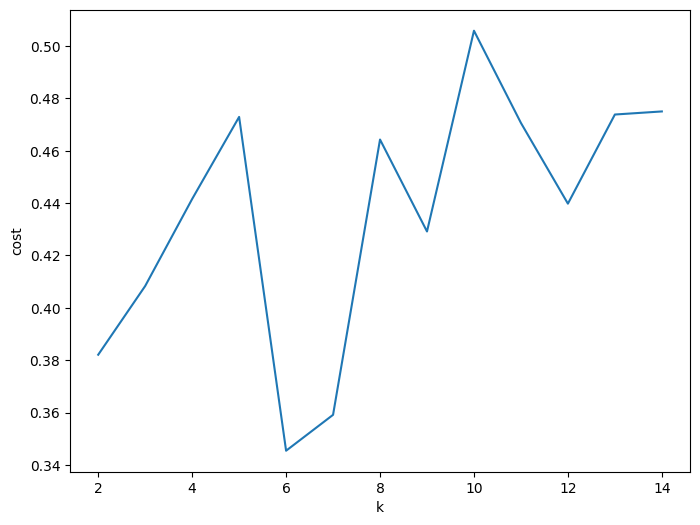

In [149]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,15),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [153]:
k = 11
kmeans = KMeans(featuresCol='scaled',k=k)
model = kmeans.fit(data_scaled)

In [156]:
predictions = model.transform(data_scaled)
predictions.show(5)

+--------------+----------------+-----------+---------------+------------------+------------------+-----------+---------------+---------------+----------------+--------------------+--------------------+----------+
| pnns_groups_1|energy-kcal_100g|energy_100g|       fat_100g|saturated-fat_100g|carbohydrates_100g|sugars_100g|  proteins_100g|      salt_100g|     sodium_100g|            features|              scaled|prediction|
+--------------+----------------+-----------+---------------+------------------+------------------+-----------+---------------+---------------+----------------+--------------------+--------------------+----------+
|       unknown|           262.0|     1096.0|           5.95|              1.19|             66.67|       2.38|          16.67|         0.0254|         0.01016|[262.0,1096.0,5.9...|[1.22440224161910...|         1|
|       unknown|             1.0|        4.0|            1.0|               1.0|               1.0|        1.0|            1.0|            1.0| 

In [163]:
cols = ["pnns_groups_1", "prediction"]
result = predictions.select(*cols)
result.show(5)

+--------------+----------+
| pnns_groups_1|prediction|
+--------------+----------+
|       unknown|         1|
|       unknown|         8|
|       unknown|         0|
|Fat and sauces|         7|
|       unknown|        10|
+--------------+----------+
only showing top 5 rows



In [176]:
result = result.toPandas()
result.to_csv("./openfood_.csv", index=False)

### Загрузка данных в MongoDB

In [208]:
from pymongo import MongoClient

client = MongoClient('mongodb://0.0.0.0:27017/')

db = client["my_db"]

db.my_data_new.drop()

for _ ,row in result.iterrows():
    db.my_data.insert_one(row.to_dict())

